# TF-IDF custom weights

In this notebook, we will attempt to add custom weights to certain parameters of the recommender model.

In [158]:
import numpy as np
import pandas as pd
from pandas import DataFrame
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from recommenders.models.tfidf.tfidf_utils import TfidfRecommender
import pickle
import copy
import psycopg2

Before running this notebook:
1. Create a PostgreSQL database with the following options:\
    dbname="training_database",\
    user="postgres",\
    password="default",\
    host="localhost",\
    port="5432"

2. From the root directory of this system, run the following command:\
`psql -U postgres -f data_system/data_storage/pg_dump.sql training_database`

This will create a PostgreSQL database with all the metadata in the SQL dump file (pg_dump.sql).

Now, we will connect to that database and extract all the metadata into a pandas data frame.

In [159]:
# Connect to the database with metadata
conn = psycopg2.connect(
    dbname="training_database",
    user="postgres",
    password="default",
    host="localhost",
    port="5432"
)
cursor = conn.cursor()
cursor.execute('SELECT * from dataset')

# Create pandas data frame with metadata
metadata = DataFrame(cursor.fetchall(), columns=['UID', 'Topic', 'Title', 'Description', 'Source', 
                                                 'Tags', 'Licenses', 'Col_names', 'Row_count', 'Col_count', 
                                                 'Entry_count', 'Null_count', 'Usability'])
conn.close()
cursor.close()

# why is each sports dataset duplicated three times???
metadata = metadata.drop_duplicates(subset="Title", keep="first").reset_index(drop=True) 
metadata.head()


,UID,Topic,Title,Description,Source,Tags,Licenses,Col_names,Row_count,Col_count,Entry_count,Null_count,Usability
0,303,sports,Find the Sports (Object Detection),I have used alot of Kaggle Datasets and I want...,kaggle,"{sports,""computer science""}",{CC-BY-SA-4.0},"{ImageID,XMin,YMin,XMax,YMax,Labels,OriginalUR...",6538,21,47887,0,0.882353
1,304,sports,Forbes Highest Paid Athletes 1990-2020,### Context\n\nHere is a completel list of the...,kaggle,{sports},{CC0-1.0},"{S.NO,Name,Nationality,""Current Rank"",""Previou...",301,8,2408,24,0.823529
2,344,education,Student Alcohol Consumption,<h2>Context:</h2>\n\nThe data were obtained in...,kaggle,"{""universities and colleges"",""public health"",""...",{CC0-1.0},"{school,sex,age,address,famsize,Pstatus,Medu,F...",1044,66,34452,0,0.852941
3,345,education,years of world education by country,This DataSet is downloaded from [https://ourwo...,kaggle,"{education,demographics,""data visualization"",""...",{CC0-1.0},{Entity;Code;Year;avg_years_of_schooling},7763,1,7763,0,1.000000
4,292,sports,2022 Game Winner Sports Betting Data,### Context\nA dear friend of mine has a sport...,kaggle,"{games,brazil,sports,gambling,python}","{""Attribution 4.0 International (CC BY 4.0)""}","{Data,Entrada,Fun├â┬º├â┬úo,Fundamento,Investim...",3691,45,27454,91,0.941176


Here is some information about the metadata pulled in:

In [160]:
metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   UID          167 non-null    int64  
 1   Topic        167 non-null    object 
 2   Title        167 non-null    object 
 3   Description  167 non-null    object 
 4   Source       167 non-null    object 
 5   Tags         167 non-null    object 
 6   Licenses     167 non-null    object 
 7   Col_names    167 non-null    object 
 8   Row_count    167 non-null    int64  
 9   Col_count    167 non-null    int64  
 10  Entry_count  167 non-null    int64  
 11  Null_count   167 non-null    int64  
 12  Usability    167 non-null    float64
dtypes: float64(1), int64(5), object(7)
memory usage: 17.1+ KB


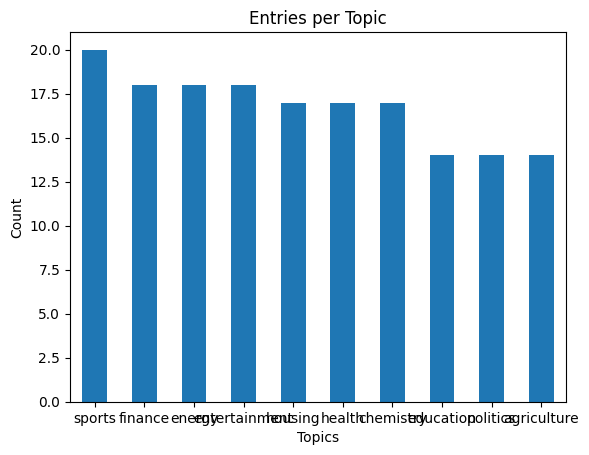

In [161]:
topic_counts = metadata['Topic'].value_counts()

topic_counts.plot(kind='bar')
plt.title('Entries per Topic')
plt.xlabel('Topics')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

In [162]:
all_tags = metadata['Tags'].tolist()
all_tags = [tag for tags_list in all_tags for tag in tags_list]
unique = set(all_tags)
num_tags= len(unique)

print(f"Number of unique tags: {num_tags}")

Number of unique tags: 31


### 2. Instantiate the recommender

These are the following tokenization methods available out-of-the-box with this implementation:

| tokenization_method | Description                                                                                                                      |
|:--------------------|:---------------------------------------------------------------------------------------------------------------------------------|
| 'none'              | No tokenization is applied. Each word is considered a token.                                                                     |
| 'nltk'              | Simple stemming is applied using NLTK.                                                                                           |
| 'bert'              | HuggingFace BERT word tokenization ('bert-base-cased') is applied.                                                               |
| 'scibert'           | SciBERT word tokenization ('allenai/scibert_scivocab_cased') is applied.<br>This is recommended for scientific journal articles. |

<i>Source: [Microsoft Recommender](https://github.com/recommenders-team/recommenders/blob/main/examples/00_quick_start/tfidf_covid.ipynb)</i>

In [163]:
# TODO: Recommender breaks if another tokenization method is used
recommender = TfidfRecommender(id_col='UID', tokenization_method='scibert')

### 3. Prepare text for use in the TF-IDF model

Here we will...

In [164]:
# Assign columns to clean and combine
cols_to_clean = ["Topic", "Title", "Description"]
clean_col = 'cleaned_text'


# metadata = metadata.astype(str) # combined columns have to all be strings
metadata[cols_to_clean] = metadata[cols_to_clean].applymap(lambda x: x.lower())

# Weighting a column by artificially inlfating its term frequency by repeating the column weight times.
# On 10/26, Nancy suggested that this is unnecessary, and weighting should instead be done on the final matrix.
    # column_to_weight = "Title"
    # weight = 5
    # metadata[column_to_weight] = metadata[column_to_weight].apply(lambda x: (x + ' ') * weight).str.rstrip()

# Combine the following columns into the one used as input in to TF-IDF
df_clean = recommender.clean_dataframe(metadata, cols_to_clean, clean_col)

df_clean.head()

,UID,Topic,Title,Description,Source,Tags,Licenses,Col_names,Row_count,Col_count,Entry_count,Null_count,Usability,cleaned_text
0,303,sports,find the sports (object detection),i have used alot of kaggle datasets and i want...,kaggle,"{sports,""computer science""}",{CC-BY-SA-4.0},"{ImageID,XMin,YMin,XMax,YMax,Labels,OriginalUR...",6538,21,47887,0,0.882353,sports find the sports object detection i have...
1,304,sports,forbes highest paid athletes 1990-2020,### context\n\nhere is a completel list of the...,kaggle,{sports},{CC0-1.0},"{S.NO,Name,Nationality,""Current Rank"",""Previou...",301,8,2408,24,0.823529,sports forbes highest paid athletes 19902020 ...
2,344,education,student alcohol consumption,<h2>context:</h2>\n\nthe data were obtained in...,kaggle,"{""universities and colleges"",""public health"",""...",{CC0-1.0},"{school,sex,age,address,famsize,Pstatus,Medu,F...",1044,66,34452,0,0.852941,education student alcohol consumption context ...
3,345,education,years of world education by country,this dataset is downloaded from [https://ourwo...,kaggle,"{education,demographics,""data visualization"",""...",{CC0-1.0},{Entity;Code;Year;avg_years_of_schooling},7763,1,7763,0,1.000000,education years of world education by country ...
4,292,sports,2022 game winner sports betting data,### context\na dear friend of mine has a sport...,kaggle,"{games,brazil,sports,gambling,python}","{""Attribution 4.0 International (CC BY 4.0)""}","{Data,Entrada,Fun├â┬º├â┬úo,Fundamento,Investim...",3691,45,27454,91,0.941176,sports 2022 game winner sports betting data c...


In [165]:
# Tokenize text with tokenization_method specified in class instantiation
tf, vectors_tokenized = recommender.tokenize_text(df_clean, text_col=clean_col)
tf

TfidfVectorizer(min_df=0, ngram_range=(1, 3), stop_words='english')

In [166]:
vectors_tokenized

0      sports find the sports object detection i have...
1      sports forb ##es highest paid athletes 1990 ##...
2      education student alcohol consumption context ...
3      education years of world education by country ...
4      sports 202 ##2 game win ##ner sports bet ##tin...
                             ...                        
162    enter ##tainment net ##fl ##ix cleaned dataset...
163    enter ##tainment nin ##ten ##do enter ##tainme...
164    enter ##tainment n ##vi ##di ##a stock data la...
165    enter ##tainment shar ##k tank ind ##ia datase...
166    enter ##tainment video game reviews ign nov 20...
Name: cleaned_text, Length: 167, dtype: object

### 4. Recommend articles using TF-IDF

In [167]:
# Fit the TF-IDF vectorizer
recommender.fit(tf, vectors_tokenized)

In [168]:
# (DOES NOT WORK, UNABLE TO SERIALIZE RECOMMENDATIONS ATTRIBUTE) Serialize model
# model_path = Path("../../backend/models/v2_model.pkl")
# with open(model_path, 'wb') as file:
#     pickle.dump(recommender, file)

In [169]:
# Get recommendations
top_k_recommendations = recommender.recommend_top_k_items(df_clean, k=10)

In [170]:
# full recommendation matrix
full_rec_matrix = recommender.recommendations
len(full_rec_matrix)

167

In [171]:
# recommendations_path = Path("../../backend/models/recommendations.pkl")
# with open(recommendations_path, 'wb') as file:
#     pickle.dump(full_rec_list, file)

In our recommendation table, each row represents a single recommendation.

- **UID** corresponds to the article that is being used to make recommendations from.
- **rec_rank** contains the recommdation's rank (e.g., rank of 1 means top recommendation).
- **rec_score** is the cosine similarity score between the query article and the recommended article.
- **rec_cord_uid** corresponds to the recommended article.

In [172]:
article_of_interest = 430
print('Number of recommended articles for ' + str(article_of_interest) + ': ' + str(len(full_rec_matrix[article_of_interest])))

Number of recommended articles for 430: 166


In [173]:
metadata[metadata["UID"] == article_of_interest]

,UID,Topic,Title,Description,Source,Tags,Licenses,Col_names,Row_count,Col_count,Entry_count,Null_count,Usability
117,430,politics,world_suicide_rates_2000-2019,suicides are preventable. suicide prevention ...,kaggle,"{""mental health"",""social science"",demographics...","{""Attribution-NonCommercial-ShareAlike 3.0 IGO...","{IndicatorCode,Indicator,ValueType,ParentLocat...",10980,34,373320,153720,0.941176


In [174]:
# Optionally view tokens
tokens = recommender.get_tokens()
# Preview 10 tokens
print(list(tokens.keys())[:10])
# Preview just the first 10 stop words sorted alphabetically
stop_words = list(recommender.get_stop_words())
stop_words.sort()
print(stop_words[:10])

['sports', 'object', 'detection', 'used', 'al', 'ot', 'ka', 'gg', 'le', 'datasets']
['a', 'about', 'above', 'across', 'after', 'afterwards', 'again', 'against', 'all', 'almost']


In [175]:
# Final Recs
cols_to_keep = cols_to_clean
recommender.get_top_k_recommendations(metadata,article_of_interest,cols_to_keep)
# TODO: why cant display UID??

,rank,similarity_score,Topic,Title,Description
0,1,0.472524,health,mental health and suicide rates,### context\n\nclose to 800 000 people die due...
1,2,0.080089,politics,politics,
2,3,0.024265,health,health insurance coverage,# context \n\nthe affordable care act (aca) is...
3,4,0.019366,politics,ideology scores of supreme court justices,# context \n\nmeasuring the relative location ...
4,5,0.018671,agriculture,european agriculture indicators,**### context**\nthe dataset is used to explor...
5,6,0.017420,energy,global energy consumption & renewable generation,\n###content \n\n4 of these datasets outline t...
6,7,0.017296,education,inequality in education around the world,### context\n\nin today's interconnected world...
7,8,0.016179,finance,finance loan approval prediction data,finance company deals in all loans. the custom...
8,9,0.016117,health,world bank wdi 2.12 - health systems,### world bank - world development indicators:...
9,10,0.016013,health,automotive vehicles engine health dataset,the dataset could include various features and...


In [176]:
# Final matrix result of all recommendations from TF-IDF
full_rec_matrix

{303: [(0.08416779789185094, 328),
  (0.08391768298273111, 327),
  (0.0501794098316291, 411),
  (0.04655039151645979, 298),
  (0.045876870828179345, 324),
  (0.04444446875835677, 330),
  (0.036298322614459685, 295),
  (0.03524799757744068, 301),
  (0.03516995213193058, 325),
  (0.03460417171699733, 300),
  (0.02978161090131205, 296),
  (0.029195012652137923, 475),
  (0.028780792293475077, 299),
  (0.026072735906217455, 374),
  (0.024141758919297537, 358),
  (0.023739925479071215, 377),
  (0.023575884330844423, 471),
  (0.02195823336173809, 318),
  (0.021452111005511483, 292),
  (0.02115775172253674, 331),
  (0.020958850690688424, 441),
  (0.018900186458117425, 395),
  (0.01845377605078273, 364),
  (0.017845292660033797, 313),
  (0.01638394915881763, 379),
  (0.015756887867278115, 439),
  (0.015603494780509717, 314),
  (0.014855425884710517, 297),
  (0.014383044723183788, 320),
  (0.013434952131750656, 354),
  (0.012922891931460918, 338),
  (0.012618906037810984, 408),
  (0.012562919373

### 5. Weighting for specific features

`full_rec_matrix` now has the raw TF-IDF scores calcualted for each dataset's title, topic, and description.
The aim is to now further refine these scores based on specific features of these datasets:

- Increase the similarity score if datasets have the same license
- Increase the similarity score if datasets share the same tag
- Increase the similarity score if this specific recommendation is positively rated

In [177]:
# Only run once
metadata.set_index('UID', inplace=True) # to index directly into metadata rows

These are the current recommendations for the given article of interest before weighting:

In [178]:
uid_of_interest = 301
metadata.loc[uid_of_interest]

Topic                                                     sports
Title                                   sports stadium locations
Description    ### content\n\ncontains the latitude and longi...
Source                                                    kaggle
Tags               {football,baseball,basketball,sports,tabular}
Licenses                                               {CC0-1.0}
Col_names                  {├»┬╗┬┐Team,League,Division,Lat,Long}
Row_count                                                    151
Col_count                                                      5
Entry_count                                                  755
Null_count                                                     0
Usability                                               0.941176
Name: 301, dtype: object

In [179]:
old_rec_list = copy.deepcopy(full_rec_matrix[uid_of_interest])
old_rec_list_UIDs = [uid for _, uid in old_rec_list]
metadata_sorted_old_recs = metadata.reindex(old_rec_list_UIDs).reset_index()
metadata_sorted_old_recs.head()

,UID,Topic,Title,Description,Source,Tags,Licenses,Col_names,Row_count,Col_count,Entry_count,Null_count,Usability
0,297,sports,nfl scores and betting data,### context\n\nnational football league histor...,kaggle,"{sports,gambling}",{CC-BY-NC-SA-4.0},"{stadium_name,stadium_location,stadium_open,st...",13952,41,236668,28093,1.000000
1,296,sports,men's professional basketball,"this dataset contains stats on players, coache...",kaggle,{basketball},{other},"{abbrev_type,code,full_name,year,coachID,award...",21821,156,394013,59750,0.852941
2,325,sports,russian register of large sports facilities 2016,"a sports venue is a building, structure, or pl...",kaggle,"{russia,sports,finance,beginner,""exploratory d...",{CC-BY-NC-SA-4.0},"{Name,Activity,SF,Locality,Address,Actions,Fir...",928,21,19488,651,0.941176
3,411,energy,sea building energy benchmarking,### content \n\nmore details about each file ...,kaggle,"{energy,socrata,electricity}",{CC0-1.0},"{OSEBuildingID,DataYear,BuildingType,PrimaryPr...",6716,93,312276,46464,0.705882
4,299,sports,political donations by american sports owners,## about data set\namerican professional sport...,kaggle,"{sports,politics,""exploratory data analysis"",""...",{CC0-1.0},"{Owner,Team,League,Recipient,Amount,""Election ...",2798,7,19586,9,1.000000


In [180]:
def extract_strings(uid, col_name):
    strings = metadata.loc[uid][col_name]
    strings = strings.strip("{}").replace('"',"")
    return {string.lower() for string in strings.split(',')}

LICENSES_WEIGHT = 1.1
TAGS_WEIGHT = 1.1
COLUMN_NAMES_WEIGHT = 1.05

for (rec_from_uid, rec_list) in full_rec_matrix.items():
    for (original_score,rec_to_uid) in rec_list:
        
        # keep track of weight that will be applied to this recommendation
        weight = 1
        
        # Increase score if datasets have the same license
        if(metadata.loc[rec_from_uid]['Licenses'] == metadata.loc[rec_to_uid]['Licenses']):
            weight *= LICENSES_WEIGHT

        # Increase score by the number of shared tags
        from_tags = extract_strings(rec_from_uid, "Tags")
        to_tags = extract_strings(rec_to_uid, "Tags")
        num_shared_tags = len(from_tags & to_tags)
        weight *= TAGS_WEIGHT ** num_shared_tags

        # Increase score by the number of column names
        from_cols = extract_strings(rec_from_uid, "Col_names")
        to_cols = extract_strings(rec_to_uid, "Col_names")
        num_shared_cols = len(from_cols & to_cols)
        weight *= COLUMN_NAMES_WEIGHT ** num_shared_cols

        # Apply the weight to this recommendation
        if(weight != 1):
            index = next((i for i, rec in enumerate(rec_list) if rec[1] == rec_to_uid), None)
            weighted_recommendation = (original_score * weight, rec_to_uid)
            rec_list[index] = weighted_recommendation

    # Reorder the recommendations based on their new weights
    rec_list.sort(key=lambda x: x[0], reverse=True)

And now these are the recommendations after weighting...

In [181]:
new_rec_list = full_rec_matrix[uid_of_interest]
new_rec_list_UIDs = [uid for _, uid in new_rec_list]
metadata_sorted = metadata.reindex(new_rec_list_UIDs).reset_index()
metadata_sorted.head()

,UID,Topic,Title,Description,Source,Tags,Licenses,Col_names,Row_count,Col_count,Entry_count,Null_count,Usability
0,297,sports,nfl scores and betting data,### context\n\nnational football league histor...,kaggle,"{sports,gambling}",{CC-BY-NC-SA-4.0},"{stadium_name,stadium_location,stadium_open,st...",13952,41,236668,28093,1.000000
1,296,sports,men's professional basketball,"this dataset contains stats on players, coache...",kaggle,{basketball},{other},"{abbrev_type,code,full_name,year,coachID,award...",21821,156,394013,59750,0.852941
2,325,sports,russian register of large sports facilities 2016,"a sports venue is a building, structure, or pl...",kaggle,"{russia,sports,finance,beginner,""exploratory d...",{CC-BY-NC-SA-4.0},"{Name,Activity,SF,Locality,Address,Actions,Fir...",928,21,19488,651,0.941176
3,299,sports,political donations by american sports owners,## about data set\namerican professional sport...,kaggle,"{sports,politics,""exploratory data analysis"",""...",{CC0-1.0},"{Owner,Team,League,Recipient,Amount,""Election ...",2798,7,19586,9,1.000000
4,324,sports,pro and college sports lines,### context\n\nafter participating in many kag...,kaggle,"{basketball,sports,""computer science"",gambling}",{CC0-1.0},"{season,date,away.team,away.score,home.team,ho...",6652,32,53216,0,0.647059


#### This is what happened to those similarity scores

In [182]:
old_rec_list

[(0.10043155673053851, 297),
 (0.08864236624105407, 296),
 (0.08352826628170812, 325),
 (0.05871623340023248, 411),
 (0.051112865181786725, 299),
 (0.05013319662253467, 324),
 (0.048918501872384224, 328),
 (0.040830297395270526, 298),
 (0.03524799757744068, 303),
 (0.03273748249822904, 327),
 (0.02796697379875604, 330),
 (0.027539852420505377, 423),
 (0.026405151218739903, 304),
 (0.025029603967997072, 320),
 (0.021449571335854685, 314),
 (0.021262815355014782, 300),
 (0.019983428797814333, 295),
 (0.01940811532910917, 362),
 (0.01616045988201604, 359),
 (0.015609591762182488, 444),
 (0.015565539399607146, 378),
 (0.015177243050149634, 292),
 (0.014965744611404222, 445),
 (0.014657480648421508, 406),
 (0.014292324060899822, 398),
 (0.014035551293651924, 427),
 (0.01320285955205305, 408),
 (0.012902164215318014, 482),
 (0.011742785037466202, 429),
 (0.011353376606275075, 352),
 (0.01124995679427769, 318),
 (0.011104882647532276, 393),
 (0.010875174336873072, 331),
 (0.010872187542880697

In [183]:
new_rec_list

[(0.11047471240359237, 297),
 (0.09750660286515948, 296),
 (0.09188109290987893, 325),
 (0.06803122355695815, 299),
 (0.06672728470459366, 324),
 (0.06458785674025573, 411),
 (0.05381035205962265, 328),
 (0.052724042938222866, 327),
 (0.044913327134797586, 298),
 (0.03877279733518475, 303),
 (0.033314402881404116, 320),
 (0.03195023297467529, 304),
 (0.030763671178631647, 330),
 (0.027539852420505377, 423),
 (0.024179948845355348, 295),
 (0.023594528469440157, 314),
 (0.023389096890516263, 300),
 (0.021348926862020088, 362),
 (0.01955415645723941, 359),
 (0.0166949673551646, 292),
 (0.016462319072544647, 445),
 (0.01612322871326366, 406),
 (0.015609591762182488, 444),
 (0.015565539399607146, 378),
 (0.014292324060899822, 398),
 (0.014192380636849817, 482),
 (0.014035551293651924, 427),
 (0.013612447721076008, 318),
 (0.01320285955205305, 408),
 (0.01315896094761642, 331),
 (0.012917063541212824, 429),
 (0.011353376606275075, 352),
 (0.011178029408293523, 420),
 (0.011105473450168598, 3